In [63]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [64]:
# Download from Kaggle: https://www.kaggle.com/prajitdatta/movielens-100k-dataset
ratings_path = "/Users/amitnarang/Downloads/ml-100k/u.data"

In [65]:
columns=["userId", "movieId", "rating", "timestamp"]
df = pd.read_csv(ratings_path, sep = '\t', names=columns)
print(df)
n_users = max(df['userId'])
n_items = max(df['movieId'])
ratings = np.zeros((n_users, n_items))
data = []
for row in df.itertuples():
    if row.userId < 5:
        data.append([row.userId, row.movieId, row.rating, row.timestamp])
    else:
        ratings[row.userId - 1, row.movieId - 1] = row.rating
stream_df = pd.DataFrame(data=data, columns=columns).sort_values("timestamp")
print(ratings)
print(stream_df)

       userId  movieId  rating  timestamp
0         196      242       3  881250949
1         186      302       3  891717742
2          22      377       1  878887116
3         244       51       2  880606923
4         166      346       1  886397596
...       ...      ...     ...        ...
99995     880      476       3  880175444
99996     716      204       5  879795543
99997     276     1090       1  874795795
99998      13      225       2  882399156
99999      12      203       3  879959583

[100000 rows x 4 columns]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
     userId  movieId  rating  timestamp
405       1      172       5  874965478
349       1      168       5  874965478
368       1      165       5  874965518
319       1      156       4  874965556
162       1      196       5  874965677
..      ...      ...     ...        ...
14        4      264       3  892

In [66]:
def create_split(stream_df, num_test = 3):
    """
    split the streaming dataframe into train and test sets
    test set --> last num_test rows for each user in the streaming dataframe
    """
    test_data = np.zeros((n_users, n_items))
    data = []
    for userId in stream_df["userId"].unique():
        user_df = stream_df[stream_df["userId"] == userId].sort_values("timestamp")
        last_rows = user_df.tail(num_test)
        for row in user_df.itertuples():
            if any(last_rows["movieId"] == row.movieId):
                test_data[row.userId - 1, row.movieId - 1] = row.rating
            else:
                data.append([row.userId, row.movieId, row.rating, row.timestamp])
    train_df = pd.DataFrame(data=data, columns=columns).sort_values("timestamp")
    
    return test_data, train_df

test, train_df = create_split(stream_df)
print(test)
print(train_df)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
     userId  movieId  rating  timestamp
0         1      172       5  874965478
1         1      168       5  874965478
2         1      165       5  874965518
3         1      156       4  874965556
4         1      196       5  874965677
..      ...      ...     ...        ...
395       4      356       3  892003459
396       4      357       4  892003525
397       4       50       5  892003526
398       4      264       3  892004275
399       4      358       2  892004275

[400 rows x 4 columns]


In [67]:
class ALSModel:
    def __init__(self, l, num_features, n_iters):
        self.l = l
        self.num_features = num_features
        self.n_iters = n_iters
        
    def fit(self, ratings):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = ratings.shape
        self.user_factors = np.random.random((self.n_user, self.num_features))
        self.item_factors = np.random.random((self.n_item, self.num_features))
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)  
        for i in range(self.n_iters):
            self.user_factors = self._als_step(ratings, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(ratings.T, self.item_factors, self.user_factors) 
        return self 
    
    def fit_stream(self, ratings, test, train_df, batch_size=5):
        '''
        when ratings stream in, add them to the rating matrix
        run ALS update for user vector on entire rating matrix 
        test on test matrix
        compute mse, add to list
        '''
        self.test_mse_record  = []
        for chunk in np.array_split(train_df, len(train_df) // (batch_size)):
            for row in chunk.itertuples():
                ratings[row.userId - 1, row.movieId - 1] = row.rating
            self.user_factors = self._als_step(ratings, self.user_factors, self.item_factors)
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            self.test_mse_record.append(test_mse)
        
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.num_features) * self.l
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        print(y_pred[mask], y_true[mask])
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse
        

In [68]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

In [69]:
als = ALSModel(n_iters = 500, num_features = 50, l = 0.2)

In [70]:
als.fit(ratings)

In [71]:
movie_factors = als.item_factors

[-0.04383079  0.00335259 -0.07012838  0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[-0.10834825  0.00282216 -0.08484653  0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[-0.12484401  0.00335239 -0.09379405  0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[-0.11007955  0.0256019  -0.14995831  0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[-0.11686978  0.03647967 -0.15325077  0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[-0.12302897  0.02103634 -0.170066    0.          0.          0.
  0.          0.          0.          0.          

[ 0.78681765  0.01608053  0.19951836  0.28079934  0.06266228 -0.01194164
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[ 0.78681765  0.01608053  0.19951836  0.41021175  0.06588787 -0.01643632
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[ 0.78681765  0.01608053  0.19951836  0.47592623  0.0677647  -0.00840158
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[ 0.78681765  0.01608053  0.19951836  0.64787746  0.05575876 -0.00827223
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[ 0.78681765  0.01608053  0.19951836  0.53513497  0.01588509 -0.01071652
  0.          0.          0.          0.          0.          0.        ] [3. 1. 2. 3. 1. 1. 4. 2. 4. 4. 4. 5.]
[ 0.81473489  0.01463907  0.22825512  0.48150388  0.06580365 -0.01045701
  

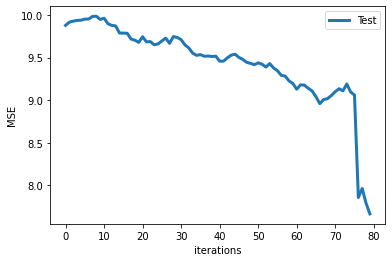

In [72]:
als.fit_stream(ratings, test, train_df)
plot_learning_curve(als)

In [73]:
len(als.test_mse_record)

80